In [ ]:
!pip install -q scikit-learn pandas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
intern_skills = pd.DataFrame({
    'Intern_ID': ['INT001', 'INT002', 'INT003', 'INT004', 'INT005'],
    'Skills': [
        "Python, HTML, CSS, JavaScript",
        "C++, Python, Machine Learning",
        "Java, SQL, Cloud Computing",
        "Data Analysis, R, Python",
        "Cybersecurity, Networking, Linux"
    ]
})

industry_demands = pd.DataFrame({
    'Job_Role': ['Web Developer', 'Data Scientist', 'Cloud Engineer', 'Network Admin', 'AI Engineer'],
    'Required_Skills': [
        "HTML, CSS, JavaScript, React",
        "Python, Machine Learning, Data Analysis",
        "AWS, Cloud Computing, DevOps, Python",
        "Networking, Linux, Firewalls, Security",
        "Python, Deep Learning, Neural Networks"
    ]
})


In [3]:
all_skills = pd.concat([
    intern_skills[['Skills']].rename(columns={"Skills": "Text"}),
    industry_demands[['Required_Skills']].rename(columns={"Required_Skills": "Text"})
], ignore_index=True)

In [4]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_skills['Text'])

In [5]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(tfidf_matrix)

KMeans(n_clusters=3, n_init=10, random_state=42)

In [6]:
all_skills['Cluster'] = kmeans.labels_
intern_skills['Cluster'] = all_skills.iloc[:len(intern_skills)]['Cluster'].values
industry_demands['Cluster'] = all_skills.iloc[len(intern_skills):]['Cluster'].values

In [7]:
def find_skill_gaps(intern_vector, job_vector, intern_text, job_text):
    intern_terms = set(intern_text.lower().split(", "))
    job_terms = set(job_text.lower().split(", "))
    missing = job_terms - intern_terms
    return list(missing)

results = []
for i, row in intern_skills.iterrows():
    intern_vector = tfidf_matrix[i]
    intern_text = row['Skills']
    intern_id = row['Intern_ID']
    cluster = row['Cluster']

    job_match = industry_demands[industry_demands['Cluster'] == cluster].iloc[0]
    job_text = job_match['Required_Skills']
    job_role = job_match['Job_Role']
    job_vector = tfidf_matrix[len(intern_skills) + industry_demands[industry_demands['Cluster'] == cluster].index[0]]

    similarity = cosine_similarity(intern_vector, job_vector)[0][0]
    skill_gaps = find_skill_gaps(intern_vector, job_vector, intern_text, job_text)

    results.append({
        'Intern_ID': intern_id,
        'Skill_Gaps': skill_gaps,
        'Similarity (%)': round(similarity * 100, 2)
    })

In [8]:
results_df = pd.DataFrame(results)
results_df['Skill_Gap_Count'] = results_df['Skill_Gaps'].apply(len)


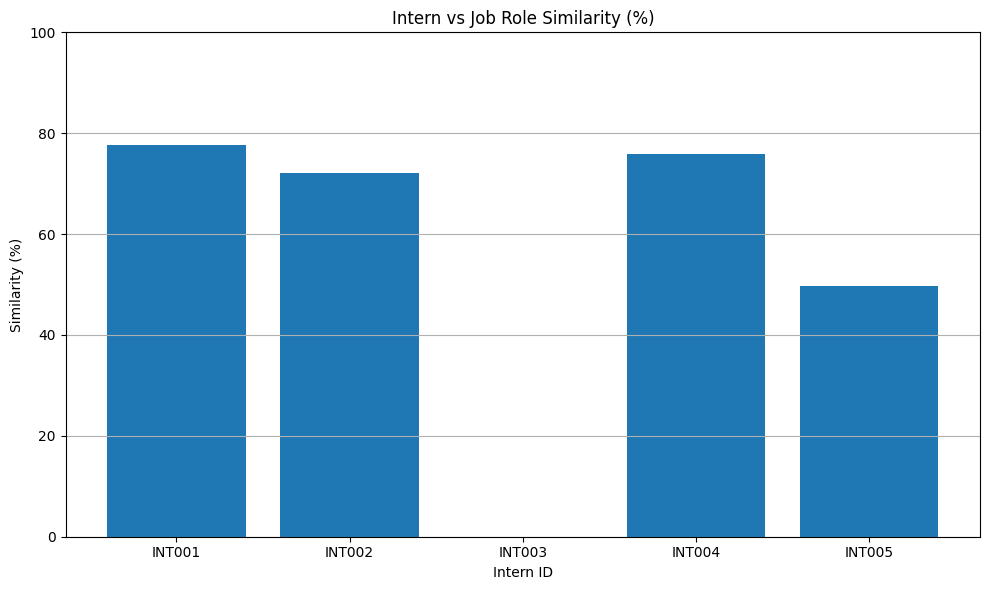

In [10]:
plt.figure(figsize=(10, 6))
plt.bar(results_df['Intern_ID'], results_df['Similarity (%)'])
plt.title("Intern vs Job Role Similarity (%)")
plt.xlabel("Intern ID")
plt.ylabel("Similarity (%)")
plt.ylim(0, 100)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


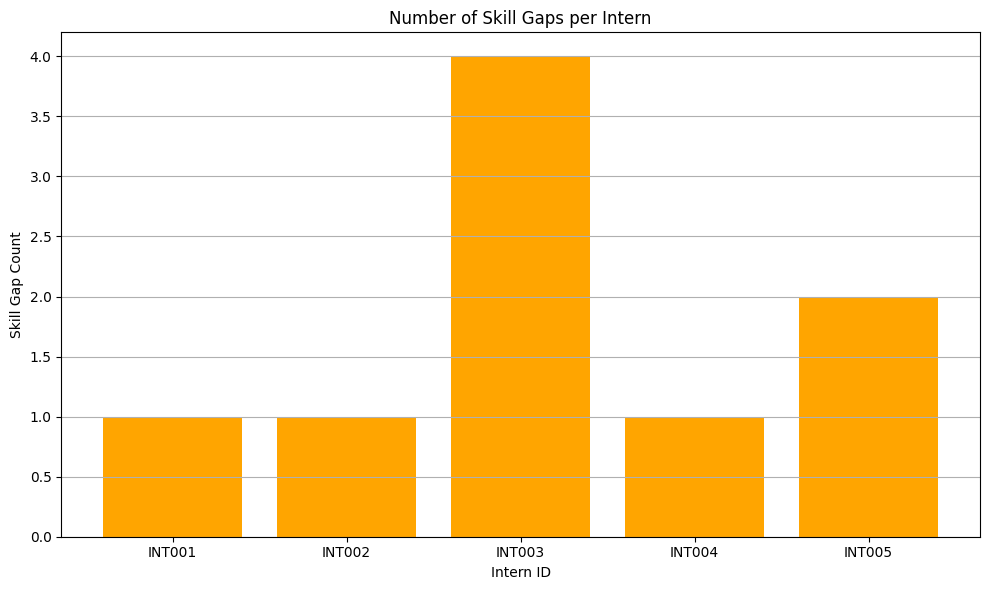

In [13]:

plt.figure(figsize=(10, 6))
plt.bar(results_df['Intern_ID'], results_df['Skill_Gap_Count'], color='orange')
plt.title("Number of Skill Gaps per Intern")
plt.xlabel("Intern ID")
plt.ylabel("Skill Gap Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()